# SOEN 6611 - Step 5 - Implementation of Measurement Process

### Business Goal
Improve quality of big data for machine learning model.

### Machine Learning Goal
The goal of the machine learning model is to predict whether a particular individual is at high/low credit risk.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

### Data Collection

Out dataset is a credit card dataset containing details of individuals like age, income etc. and a target value stating whether the particular individual is at high or low credit risk. The data is coleected in a form of CSV file and is loaded into the memory using the pandas library. 

#### Assumption
We are considering this file as a single dataset split into three time frames T1, T2 and T3.<br>
$Nds$ = number of datasets = 1

Source: https://www.kaggle.com/datasets/samuelcortinhas/credit-card-classification-clean-data

In [30]:
#import data into dataframe

df = pd.read_csv('data_manipulated.csv')

#split data frame into three parts assuming each part is a separate time frame

df_t1 = df.iloc[:4000]
df_t2 = df.iloc[4000:7000]
df_t3 = df.iloc[7000:]

print('Count:', df_t1.shape[0])
print('Count:', df_t2.shape[0])
print('Count:', df_t3.shape[0])

print(df.dtypes)

Count: 4000
Count: 3000
Count: 2920
ID                   int64
Gender             float64
Own_car            float64
Own_property       float64
Work_phone          object
Phone              float64
Email              float64
Unemployed          object
Num_children       float64
Num_family         float64
Account_length     float64
Total_income       float64
Age                float64
Years_employed     float64
Income_type         object
Education_type      object
Family_status       object
Housing_type        object
Occupation_type     object
Target             float64
Date                object
dtype: object


### Global Variables

num_request - number of requests to database. 
<br>
num_successful_request - number of successful requests to database. <br>
**It is assumed that dataframe is equivalent to database and each call to dataframe is considered as request. If the call does not return any error then num_successful_requests is incremented.** <br>

nds = number of datasets

In [31]:
num_request = 0
num_successful_request = 0
nds = 1

### Base Measure and Utility Function


In [56]:
# Method : recCount(df_list) : method to calculate total number of records in multiple datasets <br>
# Param : df_list : list of multiple dataframes 
# Return : Integer : returns total number of records in multiple datasets
def recCount(df_list):
    global num_request
    global num_successful_request
    num_records = 0
    for i in df_list:
        num_request += 1
        num_records += i.shape[0]
        num_successful_request += 1
    
    return num_records

def percentChange(x1,x2):
    return ((x2-x1) / x1) * 100



## Big Data Quality Indicators
### Veracity

Veracity refers to the degree that data is accurate, trusted and precise. It is not only the accuracy of the data itself but the trustworthiness of the data source, type, and processing of it.
<br>
$Mvar = W_{acc} * Accuracy + W_{comp} * Completeness + W_{curr} * Currentness + W_{avail} * Availability$

Derived Measures:
- Accuracy
- Completeness
- Currentness
- Availability

#### Accuracy
Degree to which data has attributes that correctly represent the true value of the intended attribute of a concept or event in a specific context of use.
<br><br>
$H_{acc} = log_2(Lbd) - (1/Lbd) * \sum{p_j * log_2(p_j)}$ <br>
$H_{max} = log_2(Lbd)$ <br>
$Accuracy = H_{acc} / H_{max}$ <br>

$Lbd$ : number of records in dataset <br>
$p_j$ : total number of duplicate records in dataset <br>
$H_{acc}$ : entropy of multiple datasets

#### Completeness
Degree to which subject data associated with an entity has values for all expected attributes and related entity instances in a specific context of use.
<br><br>
$Com_m(MDS) = \frac{rec\_no\_null(MDS)}{Lbd(MDS)}$

$Rec\_no\_null (MDS)$ : Frequency of records (in MDS) with no null values<br>
$Lbd$ : number of records in dataset <br>

#### Currentness
Degree to which data has attributes that are of the right age in a specific context of use. 
<br><br>
$Currentness(MDS) = \frac{rec\_acc\_age(MDS)}{Lbd(MDS)}$

$Rec\_acc\_age(MDS)$ : Provides the total number of records with ages that fall within the acceptable range based on the upper and lower quartiles of the Box and Whisker. <br>
$Lbd(MDS)$ : Total Number of records in MDS

#### Availability
Degree to which data has attributes that enable it to be retrieved by authorized users and/or applications in a specific context of use. 
<br><br>
$Availability(MDS) = \frac{N\_succ\_req (MDS)}{N\_req (MDS)} $

$N\_succ\_req (MDS)$ : Number of successful requests (from an API, server, datastore, origins of data, etc) <br>
$N\_req (MDS)$ : Number of requests


In [33]:
#Accuracy
def getAccuracy(df_list):
    num_records = recCount(df_list)
    global num_request
    global num_successful_request
    sum=0
    for i in df_list:
        num_request += 1
        if i.duplicated().sum() != 0:
            sum += (i.duplicated().sum() * np.log2(i.duplicated().sum()))
        num_successful_request += 1
    
    
    Hacc = np.log2(num_records) - (1/num_records) * sum
    Hmax = np.log2(num_records)
    
    return (Hacc / Hmax) 

#Completeness
def getCompleteness(df_list):
    num_records = recCount(df_list)
    global num_request
    global num_successful_request
    rec_null=0
    for i in df_list:
        num_request += 1
        rec_null += i.isnull().any(axis=1).sum()
        num_successful_request += 1
    
    return ((num_records - rec_null) / num_records)
    

#Currentness
def getCurrentness(df_list):
    
    global num_request
    global num_successful_request
    num_request+=1
    num_records = recCount(df_list)
    
    #converting string date to pandas Date type
    combine_df = pd.concat(df_list)
    combine_df = combine_df.dropna(subset=['Date'])
    combine_df['Date'] = pd.to_datetime(combine_df['Date'], format='%m/%d/%Y')
    combine_df = combine_df.sort_values(by='Date')
    
    #performing box and whisker analysis on Date column
    n = combine_df.shape[0]
    lower = np.ceil((n+1)/4).astype('int64')-1
    higher = np.ceil((3/4) *(n+1)).astype('int64')-1
    date_lower = combine_df.iloc[lower]['Date']
    date_higher = combine_df.iloc[higher]['Date']
    count = combine_df.loc[combine_df['Date'].between(date_lower,date_higher,inclusive='both')].shape[0]
    num_successful_request+=1
    return count / num_records

#Availability
def getAvailability():
    return num_successful_request / num_request

#Veracity
def getVeracity(df_list, w_acc=1/4, w_comp=1/4, w_curr=1/4 ,w_avail = 1/4):
    
    if((w_acc + w_comp + w_curr + w_avail) > 1):
        print("Sum of weights is greater than one")
        return
    
    return (w_acc * getAccuracy(df_list)) + (w_comp * getCompleteness(df_list)) + (w_curr * getCurrentness(df_list)) + (w_avail * getAvailability())

### Vincularity

Vincularity refers to the degree of connectivity and linkage of data.  

Derived Measure:
- Traceability

#### Traceability
Traceability measures provide the degree to which data has attributes that provide an audit trail of access to the data and of any changes made to the data in a specific context of use. Traceability is measured both from “Inherent” and “System dependent” point of view.

$Traceability(DS) = \frac{Rec_{trace}(DS)}{Ldst(DS)}$
<br>
$Mvin(MDS) = \frac{\sum{_{\forall DS \in MDS} Traceability(DS)}}{Nds(DS)}$
<br>

$Ldst :$ (Length of the Record): Total number of occurrences of data elements in dataset (DS)

$Rec\_Trace$ : Provides the total number of records that are traceable in MDS


In [34]:
# Validate String date format
# Using dateutil.parser.parse
from dateutil import parser

def isValidDate(test_str):
    # initializing format
    format = "%d/%m/%Y"
    # checking if format matches the date
    res = True
    # using try-except to check for truth value
    try:
        res = bool(parser.parse(test_str))
    except ValueError:
        res = False
    return res

def isTraceable(row):
    
    gender_comp =  row.Gender != '' and row.Gender == 0 or row.Gender == 1
    car_comp = row.Own_car != '' and row.Own_car == 0 or row.Own_car == 1
    property_comp = row.Own_property != '' and row.Own_property == 0 or row.Own_property == 1
    work_phone_comp = row.Work_phone != '' and row.Work_phone == '0' or row.Work_phone == '1'
    phone_comp = row.Phone != '' and row.Phone == 0 or row.Phone == 1
    email_comp = row.Email != '' and row.Email == 0 or row.Email == 1 
    unemployed_comp = row.Unemployed != '' and row.Unemployed == '0' or row.Unemployed == '1'
    children_comp = row.Num_children != '' and row.Num_children >= 0
    family_comp = row.Num_family != '' and row.Num_family >= 0
    account_comp = row.Account_length != '' and row.Account_length >= 0
    income_comp = row.Total_income != '' and row.Total_income >= 0
    age_comp = row.Age != '' and row.Age >= 0
    years_comp = row.Years_employed != '' and row.Years_employed >= 0
    income_type_comp = isinstance(row.Income_type, str) and row.Income_type != '' and len(row.Income_type) >= 0
    education_type_comp = isinstance(row.Education_type, str) and row.Education_type != '' and len(row.Education_type) >= 0
    fam_status_comp = isinstance(row.Family_status, str) and row.Family_status != '' and len(row.Family_status) >= 0
    housing_type_comp = isinstance(row.Housing_type, str) and row.Housing_type != '' and len(row.Housing_type) >= 0
    occ_type_comp = isinstance(row.Occupation_type, str) and row.Occupation_type != '' and len(row.Occupation_type) >= 0
    target_comp = row.Target != '' and row.Target == 0 or row.Target == 1 
    date_comp = row.Date != '' and isValidDate(str(row.Date))
    
    if gender_comp and car_comp and property_comp and work_phone_comp and phone_comp and email_comp and unemployed_comp\
        and children_comp and family_comp and account_comp and income_comp and age_comp and years_comp and income_type_comp\
        and education_type_comp and fam_status_comp and housing_type_comp and occ_type_comp and target_comp and date_comp:
        return True
    else:
        return False
    

# Vincularity
def getVincularity(df_list):
    global num_request
    global num_successful_request
    num_request+=1
    
    sum_mds_vinc = 0
    total_rec = recCount(df_list)
    num_vin_rec = 0
    for df in df_list:   
        for row in df.itertuples(index=False):
            if isTraceable(row):
                num_vin_rec += 1
     
    sum_mds_vinc = num_vin_rec/total_rec
    
    mds_vincularity = sum_mds_vinc/nds
    num_successful_request+=1
    return mds_vincularity

### Validity
Validity of Big Data is defined in terms of its accuracy and correctness for the purpose of usage.
<br>
Derived Measures:
- Credibility
- Compliance

#### Credibility
The degree to which data has attributes that are regarded as true and believable by users in a specific context of use.
<br>
$Credibility = \frac{Nds_{cr}}{Nds}$
<br>
$Nds_{cr}$: Number of credible  Datasets <br>
$Nds$ : Number of datasets

#### Compliance
The degree to which data has attributes that adhere to standards, conventions or regulations in force and similar rules relating to data quality in a specific context of use.
<br>
$Compliance(MDS) = \frac{\sum{_{\forall DS \in MDS}Nrec_{comp}(DS)}}{Nds(MDS)}$
<br>
$Nrec\_comp$: Number of compliant records in a Dataset <br>
$Nds\_cr$: Number of credible  Datasets


In [35]:
def isCompliant(row):

    gender_comp =  row.Gender != '' and row.Gender == 0 or row.Gender == 1
    car_comp = row.Own_car != '' and row.Own_car == 0 or row.Own_car == 1
    property_comp = row.Own_property != '' and row.Own_property == 0 or row.Own_property == 1
    work_phone_comp = row.Work_phone != '' and row.Work_phone == '0' or row.Work_phone == '1'
    phone_comp = row.Phone != '' and row.Phone == 0 or row.Phone == 1
    email_comp = row.Email != '' and row.Email == 0 or row.Email == 1 
    unemployed_comp = row.Unemployed != '' and row.Unemployed == '0' or row.Unemployed == '1'
    children_comp = row.Num_children != '' and row.Num_children >= 0
    family_comp = row.Num_family != '' and row.Num_family >= 0
    account_comp = row.Account_length != '' and row.Account_length >= 0
    income_comp = row.Total_income != '' and row.Total_income >= 0
    age_comp = row.Age != '' and row.Age >= 0
    years_comp = row.Years_employed != '' and row.Years_employed >= 0
    income_type_comp = isinstance(row.Income_type, str) and row.Income_type != '' and len(row.Income_type) >= 0
    education_type_comp = isinstance(row.Education_type, str) and row.Education_type != '' and len(row.Education_type) >= 0
    fam_status_comp = isinstance(row.Family_status, str) and row.Family_status != '' and len(row.Family_status) >= 0
    housing_type_comp = isinstance(row.Housing_type, str) and row.Housing_type != '' and len(row.Housing_type) >= 0
    occ_type_comp = isinstance(row.Occupation_type, str) and row.Occupation_type != '' and len(row.Occupation_type) >= 0
    target_comp = row.Target != '' and row.Target == 0 or row.Target == 1 
    date_comp = row.Date != '' and isValidDate(str(row.Date))
    
 
    
    if gender_comp and car_comp and property_comp and work_phone_comp and phone_comp and email_comp and unemployed_comp\
        and children_comp and family_comp and account_comp and income_comp and age_comp and years_comp and income_type_comp\
        and education_type_comp and fam_status_comp and housing_type_comp and occ_type_comp and target_comp and date_comp:
        return True
    else:
        return False
    

# Compliance
def getCompliance(df_list):
    global num_request
    global num_successful_request
    num_request+=1
    sum_mds_comp = 0
    
    total_rec = recCount(df_list)
    num_comp_rec = 0
    
    for df in df_list:      
        for row in df.itertuples(index=False):
            if isCompliant(row):
                num_comp_rec += 1
    
    sum_mds_comp = num_comp_rec/total_rec
    
    mds_compliance = sum_mds_comp/nds
    num_successful_request+=1
    return mds_compliance

# Credability - Assumed to be 1.
def getCredability(num_cred_dataset=0):
    
    mds_credability = num_cred_dataset/nds
    print("Credability: ", mds_credability)
    return mds_credability

# Validity
def getValidity(credability, cred_weight, compliance, comp_weight):
    ver = credability*cred_weight + compliance*comp_weight
    return ver

### Measuring Base Measure before processing

In [78]:
# Number of compliant records
def getNumberOfCompliantRecords(df_list):
    global num_request
    global num_successful_request
    num_request+=1
    sum_mds_comp = 0
    
    total_rec = recCount(df_list)
    num_comp_rec = 0
    
    for df in df_list:      
        for row in df.itertuples(index=False):
            if isCompliant(row):
                num_comp_rec += 1
    
    return num_comp_rec

#Number of tracable records
def getNumberOfTracableRecords(df_list):
    global num_request
    global num_successful_request
    num_request+=1
    
    sum_mds_vinc = 0
    total_rec = recCount(df_list)
    num_vin_rec = 0
    for df in df_list:   
        for row in df.itertuples(index=False):
            if isTraceable(row):
                num_vin_rec += 1
    return num_vin_rec

#Number of records for currentness
def getNumberOfCurrentRecords(df_list):
    
    global num_request
    global num_successful_request
    num_request+=1
    num_records = recCount(df_list)
    
    #converting string date to pandas Date type
    combine_df = pd.concat(df_list)
    combine_df = combine_df.dropna(subset=['Date'])
    combine_df['Date'] = pd.to_datetime(combine_df['Date'], format='%m/%d/%Y')
    combine_df = combine_df.sort_values(by='Date')

    #performing box and whisker analysis on Date column
    n = combine_df.shape[0]
    lower = np.ceil((n+1)/4).astype('int64')-1
    higher = np.ceil((3/4) *(n+1)).astype('int64')-1
    date_lower = combine_df.iloc[lower]['Date']
    date_higher = combine_df.iloc[higher]['Date']
    count = combine_df.loc[combine_df['Date'].between(date_lower,date_higher,inclusive='both')].shape[0]
    return count 

#Number of successul requests
def getNumberOfSuccessfulRequests(df_list):
    global num_request
    global num_successful_request
    num_records = 0
    requests=0
    for i in df_list:
        num_request += 1
        num_records += i.shape[0]
        num_successful_request += 1
    if num_successful_request>1:
        requests=1
    return requests

#Number of record frequency with no null value
def getNumberOfNonNullRecordFreq(df_list):
    num_records = recCount(df_list)
    global num_request
    global num_successful_request
    rec_null=0
    for i in df_list:
        num_request += 1
        rec_null += i.isnull().any(axis=1).sum()
        num_successful_request += 1
    
    return ((num_records - rec_null))

#Number of duplicate items
def getNumberOfDuplicatedItems(df_list):
    num_records = recCount(df_list)
    global num_request
    global num_successful_request
    sum=0
    for i in df_list:
        sum+=i.duplicated().sum()
    return (sum) 


11


### Measuring Base measures and Indicators before processing

In [89]:
#Number of datasets
mds_t1=1
#Number of credible datasets
mds_cred_t1=1
#Number of records 
number_records_t1=recCount([df_t1])
# Number of compliant records
compliant_records_t1=getNumberOfCompliantRecords([df_t1])
#Number of tracable records
tracable_records_t1=getNumberOfTracableRecords([df_t1])
#Number of records for currentness
current_records_t1=getNumberOfCurrentRecords([df_t1])
#Number of successul requests
successful_requests_t1=getNumberOfSuccessfulRequests([df_t1])
#Number of record frequency with no null value
non_null_records_t1=getNumberOfNonNullRecordFreq([df_t1])
#Number of duplicate items
duplicate_records_t1=getNumberOfDuplicatedItems([df_t1])
#Length od records 
length_records_t1=recCount([df_t1])

print('Number of datasets in Time Frame 1:',mds_t1)
print('Number of credible datasets in Time Frame 1:',mds_cred_t1)
print('Number of records in Time Frame 1:',number_records_t1)
print('Number of compliant records in Time Frame 1:',compliant_records_t1)
print('Number of tracable records in Time Frame 1:',tracable_records_t1)
print('Length of the records in Time Frame 1:',length_records_t1)
print('Number of Current Records in Time Frame 1:',current_records_t1)
print('Number of Successful Requests in Time Frame 1:',successful_requests_t1)
print('Number of record frequency with no null value in Time Frame 1:',non_null_records_t1)
print('Number of duplicate items in Time Frame 1:',duplicate_records_t1)
print("-------------------------------------------------")
#For Timeframe 2
#Number of datasets
mds_t2=1
#Number of credible datasets
mds_cred_t2=1
#Number of records 
number_records_t2=recCount([df_t2])
# Number of compliant records
compliant_records_t2=getNumberOfCompliantRecords([df_t2])
#Number of tracable records
tracable_records_t2=getNumberOfTracableRecords([df_t2])
#Number of records for currentness
current_records_t2=getNumberOfCurrentRecords([df_t2])
#Number of successul requests
successful_requests_t2=getNumberOfSuccessfulRequests([df_t2])
#Number of record frequency with no null value
non_null_records_t2=getNumberOfNonNullRecordFreq([df_t2])
#Number of duplicate items
duplicate_records_t2=getNumberOfDuplicatedItems([df_t2])
#Length od records 
length_records_t2=recCount([df_t2])

print('Number of datasets in Time Frame 2:',mds_t2)
print('Number of credible datasets in Time Frame 2:',mds_cred_t2)
print('Number of records in Time Frame 2:',number_records_t2)
print('Number of compliant records in Time Frame 2:',compliant_records_t2)
print('Number of tracable records in Time Frame 2:',tracable_records_t2)
print('Length of the records in Time Frame 2:',length_records_t2)
print('Number of Current Records in Time Frame 2:',current_records_t2)
print('Number of Successful Requests in Time Frame 2:',successful_requests_t2)
print('Number of record frequency with no null value in Time Frame 2:',non_null_records_t2)
print('Number of duplicate items in Time Frame 2:',duplicate_records_t2)
print("-------------------------------------------------")

#For Timeframe 3
#Number of datasets
mds_t3=1
#Number of credible datasets
mds_cred_t3=1
#Number of records 
number_records_t3=recCount([df_t3])
# Number of compliant records
compliant_records_t3=getNumberOfCompliantRecords([df_t3])
#Number of tracable records
tracable_records_t3=getNumberOfTracableRecords([df_t3])
#Number of records for currentness
current_records_t3=getNumberOfCurrentRecords([df_t3])
#Number of successul requests
successful_requests_t3=getNumberOfSuccessfulRequests([df_t3])
#Number of record frequency with no null value
non_null_records_t3=getNumberOfNonNullRecordFreq([df_t3])
#Number of duplicate items
duplicate_records_t3=getNumberOfDuplicatedItems([df_t3])
#Length od records 
length_records_t3=recCount([df_t3])

print('Number of datasets in Time Frame 3:',mds_t3)
print('Number of credible datasets in Time Frame 3:',mds_cred_t3)
print('Number of records in Time Frame 3:',number_records_t3)
print('Number of compliant records in Time Frame 3:',compliant_records_t3)
print('Number of tracable records in Time Frame 3:',tracable_records_t3)
print('Length of the records in Time Frame 3:',length_records_t3)
print('Number of Current Records in Time Frame 3:',current_records_t3)
print('Number of Successful Requests in Time Frame 3:',successful_requests_t3)
print('Number of record frequency with no null value in Time Frame 3:',non_null_records_t3)
print('Number of duplicate items in Time Frame 3:',duplicate_records_t3)
print("-------------------------------------------------")

#Veracity
accuracy_t1 = getAccuracy([df_t1])
completeness_t1 = getCompleteness([df_t1])
currentness_t1 = getCurrentness([df_t1])
availability_t1 = getAvailability()
veracity_t1 = getVeracity([df_t1],w_acc=2/6, w_comp=2/6, w_curr=1/6, w_avail=1/6)



print('Accuracy of Time Frame 1:',accuracy_t1)
print('Completeness of Time Frame 1:',completeness_t1)
print('Currentness of Time Frame 1:',currentness_t1)
print('Availability of Time Frame 1:',availability_t1)
print('Veracity of Time Frame 1:',veracity_t1)

accuracy_t2 = getAccuracy([df_t1,df_t2])
completeness_t2 = getCompleteness([df_t1,df_t2])
currentness_t2 = getCurrentness([df_t1,df_t2])
availability_t2 = getAvailability()
veracity_t2 = getVeracity([df_t1,df_t2],w_acc=2/6, w_comp=2/6, w_curr=1/6, w_avail=1/6)
print("-------------------------------------------------")
print('Accuracy of Time Frame 2:',accuracy_t2)
print('Completeness of Time Frame 2:',completeness_t2)
print('Currentness of Time Frame 2:',currentness_t2)
print('Availability of Time Frame 2:',availability_t2)
print('Veracity of Time Frame 2:',veracity_t2)

accuracy_t3 = getAccuracy([df_t1,df_t2,df_t3])
completeness_t3 = getCompleteness([df_t1,df_t2,df_t3])
currentness_t3 = getCurrentness([df_t1,df_t2,df_t3])
availability_t3 = getAvailability()
veracity_t3 = getVeracity([df_t1,df_t2,df_t3],w_acc=2/6, w_comp=2/6, w_curr=1/6, w_avail=1/6)
print("-------------------------------------------------")
print('Accuracy of Time Frame 3:',accuracy_t3)
print('Completeness of Time Frame 3:',completeness_t3)
print('Currentness of Time Frame 3:',currentness_t3)
print('Availability of Time Frame 3:',availability_t3)
print('Veracity of Time Frame 3:',veracity_t3)

Number of datasets in Time Frame 1: 1
Number of credible datasets in Time Frame 1: 1
Number of records in Time Frame 1: 4000
Number of compliant records in Time Frame 1: 3964
Number of tracable records in Time Frame 1: 3964
Length of the records in Time Frame 1: 4000
Number of Current Records in Time Frame 1: 1998
Number of Successful Requests in Time Frame 1: 1
Number of record frequency with no null value in Time Frame 1: 3966
Number of duplicate items in Time Frame 1: 11
-------------------------------------------------
Number of datasets in Time Frame 2: 1
Number of credible datasets in Time Frame 2: 1
Number of records in Time Frame 2: 3000
Number of compliant records in Time Frame 2: 2964
Number of tracable records in Time Frame 2: 2964
Length of the records in Time Frame 2: 3000
Number of Current Records in Time Frame 2: 1497
Number of Successful Requests in Time Frame 2: 1
Number of record frequency with no null value in Time Frame 2: 2966
Number of duplicate items in Time Fram

In [38]:
#Vincularity
vincularity_t1 = getVincularity([df_t1])
print("Vincularity for Time frame 1: ", vincularity_t1)

vincularity_t2 = getVincularity([df_t1,df_t2])
print("Vincularity for Time frame 2: ", vincularity_t2)

vincularity_t3 = getVincularity([df_t1,df_t2,df_t3])
print("Vincularity for Time frame 3: ", vincularity_t3)

Vincularity for Time frame 1:  0.991
Vincularity for Time frame 2:  0.9897142857142858
Vincularity for Time frame 3:  0.9834677419354839


In [39]:
#Validity
# Validity for Time frame 1
compliance_t1 = getCompliance([df_t1])
credibility_t1 = getCredability(1)
validity_t1 = getValidity(credibility_t1, 0.5,compliance_t1, 0.5)
print("Compliance for Time frame 1: ", compliance_t1)
print("Credibility for Time frame 1: ", credibility_t1)
print("Validity for Time frame 1: ", validity_t1)

# Validity for Time frame 2
compliance_t2 = getCompliance([df_t1,df_t2])
credibility_t2 = getCredability(1)
validity_t2 = getValidity(credibility_t2, 0.5,compliance_t2, 0.5)
print("------------------------------------------------")
print("Compliance for Time frame 2: ", compliance_t2)
print("Credibility for Time frame 2: ", credibility_t2)
print("Validity for Time frame 2: ", validity_t2)

# Validity for Time frame 3
compliance_t3 = getCompliance([df_t1,df_t2,df_t3])
credibility_t3 = getCredability(1)
validity_t3 = getValidity(credibility_t3, 0.5,compliance_t3, 0.5)
print("------------------------------------------------")
print("Compliance for Time frame 3: ", compliance_t3)
print("Credibility for Time frame 3: ", credibility_t3)
print("Validity for Time frame 3: ", validity_t3)

Credability:  1.0
Compliance for Time frame 1:  0.991
Credibility for Time frame 1:  1.0
Validity for Time frame 1:  0.9955
Credability:  1.0
------------------------------------------------
Compliance for Time frame 2:  0.9897142857142858
Credibility for Time frame 2:  1.0
Validity for Time frame 2:  0.9948571428571429
Credability:  1.0
------------------------------------------------
Compliance for Time frame 3:  0.9834677419354839
Credibility for Time frame 3:  1.0
Validity for Time frame 3:  0.9917338709677419


In [40]:
#Percentage change for three indicators
validity_t1t2 = percentChange(validity_t1,validity_t2)
validity_t1t3 = percentChange(validity_t1,validity_t3)
validity_t2t3 = percentChange(validity_t2,validity_t3)

print("Percentage Change for Validity Between Time frame 1 and 2: %.2f%%" % (validity_t1t2))
print("Percentage Change for Validity Between Time frame 1 and 3: %.2f%%" % (validity_t1t3))
print("Percentage Change for Validity Between Time frame 2 and 3: %.2f%%" % (validity_t2t3))

vincularity_t1t2 = percentChange(vincularity_t1,vincularity_t2)
vincularity_t1t3 = percentChange(vincularity_t1,vincularity_t3)
vincularity_t2t3 = percentChange(vincularity_t2,vincularity_t3)
print("------------------------------------------------------------------------------------")
print("Percentage Change for Vincularity Between Time frame 1 and 2: %.2f%%" % (vincularity_t1t2))
print("Percentage Change for Vincularity Between Time frame 1 and 3: %.2f%%" % (vincularity_t1t3))
print("Percentage Change for Vincularity Between Time frame 2 and 3: %.2f%%" % (vincularity_t2t3))

veracity_t1t2 = percentChange(veracity_t1,veracity_t2)
veracity_t1t3 = percentChange(veracity_t1,veracity_t3)
veracity_t2t3 = percentChange(veracity_t2,veracity_t3)
print("------------------------------------------------------------------------------------")
print("Percentage Change for Veracity Between Time frame 1 and 2: %.2f%%" % (veracity_t1t2))
print("Percentage Change for Veracity Between Time frame 1 and 3: %.2f%%" % (veracity_t1t3))
print("Percentage Change for Veracity Between Time frame 2 and 3: %.2f%%" % (veracity_t2t3))

Percentage Change for Validity Between Time frame 1 and 2: -0.06%
Percentage Change for Validity Between Time frame 1 and 3: -0.38%
Percentage Change for Validity Between Time frame 2 and 3: -0.31%
------------------------------------------------------------------------------------
Percentage Change for Vincularity Between Time frame 1 and 2: -0.13%
Percentage Change for Vincularity Between Time frame 1 and 3: -0.76%
Percentage Change for Vincularity Between Time frame 2 and 3: -0.63%
------------------------------------------------------------------------------------
Percentage Change for Veracity Between Time frame 1 and 2: -0.04%
Percentage Change for Veracity Between Time frame 1 and 3: 0.08%
Percentage Change for Veracity Between Time frame 2 and 3: 0.12%


In [41]:
#storing values for plotting
veracity_before = [veracity_t1,veracity_t2,veracity_t3]
vincularity_before = [vincularity_t1,vincularity_t2,vincularity_t3]
validity_before = [validity_t1,validity_t2,validity_t3]

In [42]:
#Average of Veracity
avg_veracity_before = np.array(veracity_before,dtype=np.float64).mean()
avg_vincularity_before = np.array(vincularity_before,dtype=np.float64).mean()
avg_validity_before = np.array(validity_before,dtype=np.float64).mean()
print("Average of Veracity before processing:", avg_veracity_before)
print("Average of Vincularity before processing:", avg_vincularity_before)
print("Average of Validity before processing:", avg_validity_before)

Average of Veracity before processing: 0.9136156770275575
Average of Vincularity before processing: 0.9880606758832565
Average of Validity before processing: 0.9940303379416283


### Analyzing Data

In this step we inspect the data elements which do not conform to the standards of the data column.

In [43]:
# checking for null values
df.isna().sum()

ID                  0
Gender             16
Own_car            16
Own_property       16
Work_phone         44
Phone              20
Email              16
Unemployed         16
Num_children       16
Num_family         44
Account_length     16
Total_income       16
Age                16
Years_employed     16
Income_type        16
Education_type     16
Family_status      16
Housing_type       16
Occupation_type    16
Target             16
Date               16
dtype: int64

There are null values in all the columns except ID and these rows with null values needs to be removed as part of cleaning the dataset.

In [44]:
#checking duplicate records
df.duplicated().sum()

11

There are 11 duplicate rows which needs to be removed.

In [45]:
# checking for gender, own_car, own_property, work_phone, phone, email, unemployed and Target columns not having values 1 or 0
count_gender = (~df['Gender'].isna() & ~df['Gender'].isin([1,0])).sum()
count_car = (~df['Own_car'].isna() & ~df['Own_car'].isin([1,0])).sum()
count_property = (~df['Own_property'].isna() & ~df['Own_property'].isin([1,0])).sum()
count_work_phone = (~df['Work_phone'].isna() & ~df['Work_phone'].isin(['1','0'])).sum()
count_phone = (~df['Phone'].isna() & ~df['Phone'].isin([1,0])).sum()
count_email = (~df['Email'].isna() & ~df['Email'].isin([1,0])).sum()
count_unemployed = (~df['Unemployed'].isna() & ~df['Unemployed'].isin(['1','0'])).sum()
count_target = (~df['Target'].isna() & ~df['Target'].isin([1,0])).sum()
count_num_children = (~df['Num_children'].isna() & ~df['Num_children'].astype(str).str.contains('[0-9]+')).sum()
count_num_family = (~df['Num_family'].isna() & ~df['Num_family'].astype(str).str.contains('[0-9]+')).sum()
count_account_length = (~df['Account_length'].isna() & ~df['Account_length'].astype(str).str.contains('[0-9]+')).sum()
count_total_income = (~df['Total_income'].isna() & ~df['Total_income'].astype(str).str.contains('[0-9]+')).sum()
count_age = (~df['Age'].isna() & ~df['Age'].astype(str).str.contains('[0-9]+')).sum()
count_years_employed = (~df['Years_employed'].isna() & ~df['Years_employed'].astype(str).str.contains('[0-9]+')).sum()
count_income_type = (~df['Income_type'].isna() & ~df['Income_type'].astype(str).str.contains('[a-zA-Z]+')).sum()
count_education_type = (~df['Education_type'].isna() & ~df['Education_type'].astype(str).str.contains('[a-zA-Z]+')).sum()
count_family_status = (~df['Family_status'].isna() & ~df['Family_status'].astype(str).str.contains('[a-zA-Z]+')).sum()
count_housing_type = (~df['Housing_type'].isna() & ~df['Housing_type'].astype(str).str.contains('[a-zA-Z]+')).sum()
count_occupation_type = (~df['Occupation_type'].isna() & ~df['Occupation_type'].astype(str).str.contains('[a-zA-Z]+')).sum()
count_date = (~df['Date'].isna() & ~df['Date'].astype(str).str.contains('^([1-9]|1[0-2])(\/)([1-9]|1[0-9]|2[0-9]|3[0-1])(\/)([12][0-9][0-9][0-9])$')).sum()

print('Non Numeric Values Gender:', count_gender)
print('Non Numeric Values Car:', count_car)
print('Non Numeric Values Property:', count_property)
print('Non Numeric Values Work Phone:', count_work_phone)
print('Non Numeric Values Phone:', count_phone)
print('Non Numeric Values Email:', count_email)
print('Non Numeric Values Unemployed:', count_unemployed)
print('Non Numeric Values Target:', count_target)
print('Non Numeric Values Number of children:', count_num_children)
print('Non Numeric Values Number of family:', count_num_family)
print('Non Numeric Values Account Length:', count_account_length)
print('Non Numeric Values Total Income:', count_total_income)
print('Non Numeric Values Age:', count_age)
print('Non Numeric Values Years Employed:', count_years_employed)
print('Non Numeric Values Income Type:', count_income_type)
print('Non Numeric Values Education Type:', count_education_type)
print('Non Numeric Values Family Status:', count_family_status)
print('Non Numeric Values Housing Type:', count_housing_type)
print('Non Numeric Values Occupation Type:', count_occupation_type)
print('Non Numeric Values Date:', count_date)

Non Numeric Values Gender: 8
Non Numeric Values Car: 0
Non Numeric Values Property: 0
Non Numeric Values Work Phone: 13
Non Numeric Values Phone: 124
Non Numeric Values Email: 0
Non Numeric Values Unemployed: 135
Non Numeric Values Target: 144
Non Numeric Values Number of children: 0
Non Numeric Values Number of family: 0
Non Numeric Values Account Length: 0
Non Numeric Values Total Income: 0
Non Numeric Values Age: 0
Non Numeric Values Years Employed: 0
Non Numeric Values Income Type: 0
Non Numeric Values Education Type: 0
Non Numeric Values Family Status: 0
Non Numeric Values Housing Type: 0
Non Numeric Values Occupation Type: 0
Non Numeric Values Date: 0


We can see that columns : Work Phone, Phone, Target, Unemployed have different values than expected values therefore these rows needs to be removed.

### Data Processing

Processing each and every column of the dataset to remove null values and values which are not suitable for columns. <br>
For Example:
- Unemployed column has values which are alphabets however it should have boolean value 1 or 0
- Age column was in decimal however it should be an integer
- Phone column is a boolean column stating that does the person has a phone or not but it had other integer values than 0 or 1

In [46]:
def processData(df):
    
    #remove rows with atleast 1 null value
    df=df.dropna()

    df = df.drop_duplicates()

    df = df[~df['Gender'].isna() & df['Gender'].isin([1,0])]
    df = df[~df['Own_car'].isna() & df['Own_car'].isin([1,0])]
    df = df[~df['Own_property'].isna() & df['Own_property'].isin([1,0])]
    df = df[~df['Work_phone'].isna() & df['Work_phone'].isin(['1','0'])]
    df = df[~df['Phone'].isna() & df['Phone'].isin([1,0])]
    df = df[~df['Email'].isna() & df['Email'].isin([1,0])]
    df = df[~df['Unemployed'].isna() & df['Unemployed'].isin(['1','0'])]
    df = df[~df['Target'].isna() & df['Target'].isin([1,0])]
    df = df[~df['Num_children'].isna() & df['Num_children'].astype(str).str.contains('[0-9]+')]
    df = df[~df['Num_family'].isna() & df['Num_family'].astype(str).str.contains('[0-9]+')]
    df = df[~df['Account_length'].isna() & df['Account_length'].astype(str).str.contains('[0-9]+')]
    df = df[~df['Total_income'].isna() & df['Total_income'].astype(str).str.contains('[0-9]+')]
    df = df[~df['Age'].isna() & df['Age'].astype(str).str.contains('[0-9]+')]
    df['Age'] = df['Age'].apply(np.floor).astype('int64')
    df = df[~df['Years_employed'].isna() & df['Years_employed'].astype(str).str.contains('[0-9]+')]
    df = df[~df['Income_type'].isna() & df['Income_type'].astype(str).str.contains('[a-zA-Z]+')]
    df = df[~df['Education_type'].isna() & df['Education_type'].astype(str).str.contains('[a-zA-Z]+')]
    df = df[~df['Family_status'].isna() & df['Family_status'].astype(str).str.contains('[a-zA-Z]+')]
    df = df[~df['Housing_type'].isna() & df['Housing_type'].astype(str).str.contains('[a-zA-Z]+')]
    df = df[~df['Occupation_type'].isna() & df['Occupation_type'].astype(str).str.contains('[a-zA-Z]+')]
    df = df[~df['Date'].isna() & df['Date'].astype(str).str.contains('^([1-9]|1[0-2])(\/)([1-9]|1[0-9]|2[0-9]|3[0-1])(\/)([12][0-9][0-9][0-9])$')]

    return df

#Function call
df_t1_processed = processData(df_t1)
df_t2_processed = processData(df_t2)
df_t3_processed = processData(df_t3)

print('Count:', df_t1_processed.shape[0])
print('Count:', df_t2_processed.shape[0])
print('Count:', df_t3_processed.shape[0])

Count: 3953
Count: 2964
Count: 2828


### Measuring Indicators after processing

In [90]:
#Number of datasets
mds_t1=1
#Number of credible datasets
mds_cred_t1=1
#Number of records 
number_records_t1=recCount([df_t1_processed])
# Number of compliant records
compliant_records_t1=getNumberOfCompliantRecords([df_t1_processed])
#Number of tracable records
tracable_records_t1=getNumberOfTracableRecords([df_t1_processed])
#Number of records for currentness
current_records_t1=getNumberOfCurrentRecords([df_t1_processed])
#Number of successul requests
successful_requests_t1=getNumberOfSuccessfulRequests([df_t1_processed])
#Number of record frequency with no null value
non_null_records_t1=getNumberOfNonNullRecordFreq([df_t1_processed])
#Number of duplicate items
duplicate_records_t1=getNumberOfDuplicatedItems([df_t1_processed])
#Length od records 
length_records_t1=recCount([df_t1_processed])

print('Number of datasets in Time Frame 1:',mds_t1)
print('Number of credible datasets in Time Frame 1:',mds_cred_t1)
print('Number of records in Time Frame 1:',number_records_t1)
print('Number of compliant records in Time Frame 1:',compliant_records_t1)
print('Number of tracable records in Time Frame 1:',tracable_records_t1)
print('Length of the records in Time Frame 1:',length_records_t1)
print('Number of Current Records in Time Frame 1:',current_records_t1)
print('Number of Successful Requests in Time Frame 1:',successful_requests_t1)
print('Number of record frequency with no null value in Time Frame 1:',non_null_records_t1)
print('Number of duplicate items in Time Frame 1:',duplicate_records_t1)
print("-------------------------------------------------")
#For Timeframe 2
#Number of datasets
mds_t2=1
#Number of credible datasets
mds_cred_t2=1
#Number of records 
number_records_t2=recCount([df_t2_processed])
# Number of compliant records
compliant_records_t2=getNumberOfCompliantRecords([df_t2_processed])
#Number of tracable records
tracable_records_t2=getNumberOfTracableRecords([df_t2_processed])
#Number of records for currentness
current_records_t2=getNumberOfCurrentRecords([df_t2_processed])
#Number of successul requests
successful_requests_t2=getNumberOfSuccessfulRequests([df_t2_processed])
#Number of record frequency with no null value
non_null_records_t2=getNumberOfNonNullRecordFreq([df_t2_processed])
#Number of duplicate items
duplicate_records_t2=getNumberOfDuplicatedItems([df_t2_processed])
#Length od records 
length_records_t2=recCount([df_t2_processed])

print('Number of datasets in Time Frame 2:',mds_t2)
print('Number of credible datasets in Time Frame 2:',mds_cred_t2)
print('Number of records in Time Frame 2:',number_records_t2)
print('Number of compliant records in Time Frame 2:',compliant_records_t2)
print('Number of tracable records in Time Frame 2:',tracable_records_t2)
print('Length of the records in Time Frame 2:',length_records_t2)
print('Number of Current Records in Time Frame 2:',current_records_t2)
print('Number of Successful Requests in Time Frame 2:',successful_requests_t2)
print('Number of record frequency with no null value in Time Frame 2:',non_null_records_t2)
print('Number of duplicate items in Time Frame 2:',duplicate_records_t2)
print("-------------------------------------------------")

#For Timeframe 3
#Number of datasets
mds_t3=1
#Number of credible datasets
mds_cred_t3=1
#Number of records 
number_records_t3=recCount([df_t3_processed])
# Number of compliant records
compliant_records_t3=getNumberOfCompliantRecords([df_t3_processed])
#Number of tracable records
tracable_records_t3=getNumberOfTracableRecords([df_t3_processed])
#Number of records for currentness
current_records_t3=getNumberOfCurrentRecords([df_t3_processed])
#Number of successul requests
successful_requests_t3=getNumberOfSuccessfulRequests([df_t3_processed])
#Number of record frequency with no null value
non_null_records_t3=getNumberOfNonNullRecordFreq([df_t3_processed])
#Number of duplicate items
duplicate_records_t3=getNumberOfDuplicatedItems([df_t3_processed])
#Length od records 
length_records_t3=recCount([df_t3_processed])

print('Number of datasets in Time Frame 3:',mds_t3)
print('Number of credible datasets in Time Frame 3:',mds_cred_t3)
print('Number of records in Time Frame 3:',number_records_t3)
print('Number of compliant records in Time Frame 3:',compliant_records_t3)
print('Number of tracable records in Time Frame 3:',tracable_records_t3)
print('Length of the records in Time Frame 3:',length_records_t3)
print('Number of Current Records in Time Frame 3:',current_records_t3)
print('Number of Successful Requests in Time Frame 3:',successful_requests_t3)
print('Number of record frequency with no null value in Time Frame 3:',non_null_records_t3)
print('Number of duplicate items in Time Frame 3:',duplicate_records_t3)
print("-------------------------------------------------")


#Veracity
accuracy_t1 = getAccuracy([df_t1_processed])
completeness_t1 = getCompleteness([df_t1_processed])
currentness_t1 = getCurrentness([df_t1_processed])
availability_t1 = getAvailability()
veracity_t1 = getVeracity([df_t1_processed],w_acc=2/6, w_comp=2/6, w_curr=1/6, w_avail=1/6)

print('Accuracy of Time Frame 1:',accuracy_t1)
print('Completeness of Time Frame 1:',completeness_t1)
print('Currentness of Time Frame 1:',currentness_t1)
print('Availability of Time Frame 1:',availability_t1)
print('Veracity of Time Frame 1:',veracity_t1)

accuracy_t2 = getAccuracy([df_t1_processed,df_t2_processed])
completeness_t2 = getCompleteness([df_t1_processed,df_t2_processed])
currentness_t2 = getCurrentness([df_t1_processed,df_t2_processed])
availability_t2 = getAvailability()
veracity_t2 = getVeracity([df_t1_processed,df_t2_processed],w_acc=2/6, w_comp=2/6, w_curr=1/6, w_avail=1/6)
print("-------------------------------------------------")
print('Accuracy of Time Frame 2:',accuracy_t2)
print('Completeness of Time Frame 2:',completeness_t2)
print('Currentness of Time Frame 2:',currentness_t2)
print('Availability of Time Frame 2:',availability_t2)
print('Veracity of Time Frame 2:',veracity_t2)

accuracy_t3 = getAccuracy([df_t1_processed,df_t2_processed,df_t3_processed])
completeness_t3 = getCompleteness([df_t1_processed,df_t2_processed,df_t3_processed])
currentness_t3 = getCurrentness([df_t1_processed,df_t2_processed,df_t3_processed])
availability_t3 = getAvailability()
veracity_t3 = getVeracity([df_t1_processed,df_t2_processed,df_t3],w_acc=2/6, w_comp=2/6, w_curr=1/6, w_avail=1/6)
print("-------------------------------------------------")
print('Accuracy of Time Frame 3:',accuracy_t3)
print('Completeness of Time Frame 3:',completeness_t3)
print('Currentness of Time Frame 3:',currentness_t3)
print('Availability of Time Frame 3:',availability_t3)
print('Veracity of Time Frame 3:',veracity_t3)

Number of datasets in Time Frame 1: 1
Number of credible datasets in Time Frame 1: 1
Number of records in Time Frame 1: 3953
Number of compliant records in Time Frame 1: 3953
Number of tracable records in Time Frame 1: 3953
Length of the records in Time Frame 1: 3953
Number of Current Records in Time Frame 1: 1981
Number of Successful Requests in Time Frame 1: 1
Number of record frequency with no null value in Time Frame 1: 3953
Number of duplicate items in Time Frame 1: 0
-------------------------------------------------
Number of datasets in Time Frame 2: 1
Number of credible datasets in Time Frame 2: 1
Number of records in Time Frame 2: 2964
Number of compliant records in Time Frame 2: 2964
Number of tracable records in Time Frame 2: 2964
Length of the records in Time Frame 2: 2964
Number of Current Records in Time Frame 2: 1483
Number of Successful Requests in Time Frame 2: 1
Number of record frequency with no null value in Time Frame 2: 2964
Number of duplicate items in Time Frame

In [48]:
#Vincularity
vincularity_t1 = getVincularity([df_t1_processed])
print("Vincularity for Time frame 1: ", vincularity_t1)

vincularity_t2 = getVincularity([df_t1_processed,df_t2_processed])
print("Vincularity for Time frame 2: ", vincularity_t2)

vincularity_t3 = getVincularity([df_t1_processed,df_t2_processed,df_t3_processed])
print("Vincularity for Time frame 3: ", vincularity_t3)

Vincularity for Time frame 1:  1.0
Vincularity for Time frame 2:  1.0
Vincularity for Time frame 3:  1.0


In [49]:
#Validity
# Validity for Time frame 1
compliance_t1 = getCompliance([df_t1_processed])
credibility_t1 = getCredability(1)
validity_t1 = getValidity(credibility_t1, 0.5,compliance_t1, 0.5)
print("Compliance for Time frame 1: ", compliance_t1)
print("Credibility for Time frame 1: ", credibility_t1)
print("Validity for Time frame 1: ", validity_t1)

# Validity for Time frame 2
compliance_t2 = getCompliance([df_t1_processed,df_t2_processed])
credibility_t2 = getCredability(1)
validity_t2 = getValidity(credibility_t2, 0.5,compliance_t2, 0.5)
print("------------------------------------------------")
print("Compliance for Time frame 2: ", compliance_t2)
print("Credibility for Time frame 2: ", credibility_t2)
print("Validity for Time frame 2: ", validity_t2)

# Validity for Time frame 3
compliance_t3 = getCompliance([df_t1_processed,df_t2_processed,df_t3_processed])
credibility_t3 = getCredability(1)
validity_t3 = getValidity(credibility_t3, 0.5,compliance_t3, 0.5)
print("------------------------------------------------")
print("Compliance for Time frame 3: ", compliance_t3)
print("Credibility for Time frame 3: ", credibility_t3)
print("Validity for Time frame 3: ", validity_t3)

Credability:  1.0
Compliance for Time frame 1:  1.0
Credibility for Time frame 1:  1.0
Validity for Time frame 1:  1.0
Credability:  1.0
------------------------------------------------
Compliance for Time frame 2:  1.0
Credibility for Time frame 2:  1.0
Validity for Time frame 2:  1.0
Credability:  1.0
------------------------------------------------
Compliance for Time frame 3:  1.0
Credibility for Time frame 3:  1.0
Validity for Time frame 3:  1.0


In [50]:
#Percentage change for three indicators
validity_t1t2 = percentChange(validity_t1,validity_t2)
validity_t1t3 = percentChange(validity_t1,validity_t3)
validity_t2t3 = percentChange(validity_t2,validity_t3)

print("Percentage Change for Validity Between Time frame 1 and 2: %.2f%%" % (validity_t1t2))
print("Percentage Change for Validity Between Time frame 1 and 3: %.2f%%" % (validity_t1t3))
print("Percentage Change for Validity Between Time frame 2 and 3: %.2f%%" % (validity_t2t3))

vincularity_t1t2 = percentChange(vincularity_t1,vincularity_t2)
vincularity_t1t3 = percentChange(vincularity_t1,vincularity_t3)
vincularity_t2t3 = percentChange(vincularity_t2,vincularity_t3)
print("------------------------------------------------------------------------------------")
print("Percentage Change for Vincularity Between Time frame 1 and 2: %.2f%%" % (vincularity_t1t2))
print("Percentage Change for Vincularity Between Time frame 1 and 3: %.2f%%" % (vincularity_t1t3))
print("Percentage Change for Vincularity Between Time frame 2 and 3: %.2f%%" % (vincularity_t2t3))

veracity_t1t2 = percentChange(veracity_t1,veracity_t2)
veracity_t1t3 = percentChange(veracity_t1,veracity_t3)
veracity_t2t3 = percentChange(veracity_t2,veracity_t3)
print("------------------------------------------------------------------------------------")
print("Percentage Change for Veracity Between Time frame 1 and 2: %.2f%%" % (veracity_t1t2))
print("Percentage Change for Veracity Between Time frame 1 and 3: %.2f%%" % (veracity_t1t3))
print("Percentage Change for Veracity Between Time frame 2 and 3: %.2f%%" % (veracity_t2t3))

Percentage Change for Validity Between Time frame 1 and 2: 0.00%
Percentage Change for Validity Between Time frame 1 and 3: 0.00%
Percentage Change for Validity Between Time frame 2 and 3: 0.00%
------------------------------------------------------------------------------------
Percentage Change for Vincularity Between Time frame 1 and 2: 0.00%
Percentage Change for Vincularity Between Time frame 1 and 3: 0.00%
Percentage Change for Vincularity Between Time frame 2 and 3: 0.00%
------------------------------------------------------------------------------------
Percentage Change for Veracity Between Time frame 1 and 2: -0.01%
Percentage Change for Veracity Between Time frame 1 and 3: -0.01%
Percentage Change for Veracity Between Time frame 2 and 3: 0.00%


In [51]:
#storing values for plotting
veracity_after = [veracity_t1,veracity_t2,veracity_t3]
vincularity_after = [vincularity_t1,vincularity_t2,vincularity_t3]
validity_after = [validity_t1,validity_t2,validity_t3]

In [52]:
#Average of Veracity
avg_veracity_after = np.array(veracity_after,dtype=np.float64).mean()
avg_vincularity_after = np.array(vincularity_after,dtype=np.float64).mean()
avg_validity_after = np.array(validity_after,dtype=np.float64).mean()
print("Average of Veracity before processing:", avg_veracity_after)
print("Average of Vincularity before processing:", avg_vincularity_after)
print("Average of Validity before processing:", avg_validity_after)

Average of Veracity before processing: 0.9167890827321533
Average of Vincularity before processing: 1.0
Average of Validity before processing: 1.0


In [53]:
#Percentage change in indicators before and after processing
print("Percentage Change in Veracity before and after processing: %.2f%%" % (percentChange(avg_veracity_before,avg_veracity_after)))
print("Percentage Change in Vincularity before and after processing: %.2f%%" % (percentChange(avg_vincularity_before,avg_vincularity_after)))
print("Percentage Change in Validity before and after processing: %.2f%%" % (percentChange(avg_validity_before,avg_validity_after)))

Percentage Change in Veracity before and after processing: 0.35%
Percentage Change in Vincularity before and after processing: 1.21%
Percentage Change in Validity before and after processing: 0.60%


### Visualizing Indicators

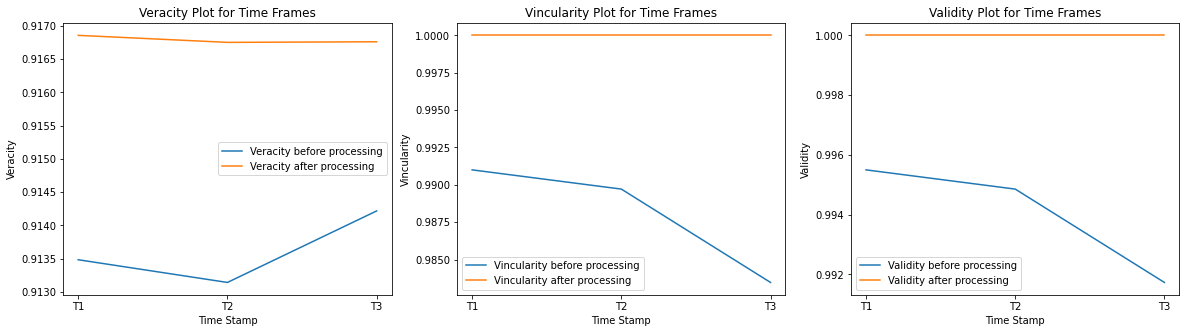

In [54]:
#Veracity Plot
X_axis = ["T1","T2","T3"]

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(X_axis,veracity_before,label="Veracity before processing")
plt.plot(X_axis,veracity_after,label="Veracity after processing",)
plt.title("Veracity Plot for Time Frames")
plt.xlabel("Time Stamp")
plt.ylabel("Veracity")
plt.legend()

plt.subplot(1,3,2)
plt.plot(X_axis,vincularity_before,label="Vincularity before processing")
plt.plot(X_axis,vincularity_after,label="Vincularity after processing",)
plt.title("Vincularity Plot for Time Frames")
plt.xlabel("Time Stamp")
plt.ylabel("Vincularity")
plt.legend()

plt.subplot(1,3,3)
plt.plot(X_axis,validity_before,label="Validity before processing")
plt.plot(X_axis,validity_after,label="Validity after processing",)
plt.title("Validity Plot for Time Frames")
plt.xlabel("Time Stamp")
plt.ylabel("Validity")
plt.legend()

plt.show()

### Interpretation

From the data gathered from the measurement we can analyze the trend of Veracity, Vincularity and Validity from different time frame before and after processing. 
<br>
#### Success Criteria
##### Veracity
Veracity >= 0.8<br>
Percentage drop in between any two time frames <= 5%

##### Vincularity
Vincularity >= 0.6<br>
Percentage drop in between any two time frames <= 10%

##### Validity
Validity >= 0.8<br>

#### Gathered Data

| Measure| T1 (Before) | T2 (Before) | T3 (Before) | Average (Before) | T1 (After) | T2 (After) | T3 (After) | Average (After) |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Veracity | 0.9134 | 0.9134 | 0.9142 | 0.9136 | 0.9168 | 0.9167 | 0.9167 | 0.9167 |
| Vincularity | 0.991 | 0.9897 | 0.9834 | 0.9880 | 1 | 1 | 1 | 1 |
| Validity | 0.9955 | 0.9948 | 0.9917 | 0.9940 | 1 | 1 | 1 | 1 |


| Time Frame | Veracity | Vincularity | Validity |
| :-: | :-: | :-: | :-: |
| T1-T2 (Before) | -0.04 | -0.13 | -0.06  |
| T1-T3 (Before) |  0.08 | -0.76 | -0.38 |
| T2-T3 (Before) | 0.12 | -0.63 | -0.31 |
| T1-T2 (After) | -0.01 | 0 | 0 |
| T1-T3 (After) | -0.01 | 0 | 0 |
| T2-T3 (After) |  0 | 0 | 0 |
| Average(Before) - Average(After) | 0.35 | 1.21 | 0.6 |

From the above we can interpret that the veracity, vinculaarity and validity before and after processing are above the success criteria. The percentage change in all the three before and after processing is less than 1.5% in positive direction which means that all the three measures have improved after preprocessing by very small margin. Vincularity and Validity reach value of 1.0 meaning that all the records are compliant and traceable in the dataset after processing. Veracity however is 0.91 due to the currentness of records. In analyzing the trend in time frames in before and after processing we can see that veracity has slightly decreased from T1 and T2 and then increased from T2 to T3. Vincularity and Validity show a downwards trend before processing by small margin as they have negative percentage difference. After preprocessing the values vincularity and validuty have reached 1.0 and have remained constant. Veracity has decreased by 0.01% from T1 and T2 and have remained constant since then. After analyzing above data we can conclude that the quality of big data before and after processing is within acceptable standards and it can be used to train machine learning model.

